# Functions that will work on the background

## Image Segmentation

### Get bounding boxes from image from user interaction

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from PIL import Image

In [5]:
rect_start = None
rect_end = None
drawing = False

In [6]:
def draw_rectangle(event, x, y, flags, param):
    """Mouse callback function to draw a rectangle."""
    global rect_start, rect_end, drawing

    if event == cv2.EVENT_LBUTTONDOWN:
        rect_start = (x, y)
        drawing = True

    elif event == cv2.EVENT_LBUTTONUP:
        rect_end = (x, y)
        drawing = False
        cv2.rectangle(img_display, rect_start, rect_end, (255, 0, 0), 4)
        cv2.imshow("Draw Rectangle", img_display)

In [7]:
def interactive_bbox_selection(image_path, window_width=800, window_height=800):
    """Allows the user to draw a rectangle and converts to Ultralytics BBox format."""
    global img_display
    
    # Load image
    img = cv2.imread(image_path)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_display = img.copy()

    cv2.namedWindow("Draw Rectangle", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Draw Rectangle", window_width, window_height)  # Resize window

    # Set mouse callback
    cv2.setMouseCallback("Draw Rectangle", draw_rectangle)

    while True:
        cv2.imshow("Draw Rectangle", img_display)
        key = cv2.waitKey(1) & 0xFF
        if key == 13:  # Press 'Enter' to finish
            break

    cv2.destroyAllWindows()

    # Convert to Ultralytics BBox format (normalized)
    if rect_start and rect_end:
        x1, y1 = rect_start
        x2, y2 = rect_end

        # Ensure coordinates are sorted properly
        x_min, y_min = min(x1, x2), min(y1, y2)
        x_max, y_max = max(x1, x2), max(y1, y2)

        # Convert to Ultralytics normalized BBox format
        coord = [
            x_min,
            y_min,
            x_max,
            y_max
        ]
        
        print("Coordinates:", coord)
        return coord
    else:
        print("No rectangle was drawn.")
        return None

In [10]:
coord = interactive_bbox_selection("frames/frame_0000.png")

Coordinates: [123, 65, 948, 1673]


### Segment image based on rectangle coordinates


image 1/1 c:\Users\gusta\Documents\Projetos Diversao\MiniAid\test_image.jpg: 640x640 1 0, 4251.6ms
Speed: 7.5ms preprocess, 4251.6ms inference, 80.9ms postprocess per image at shape (1, 3, 640, 640)


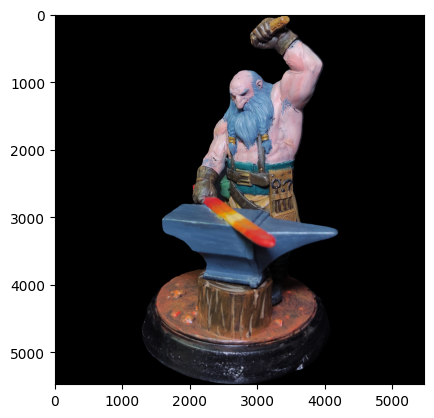

In [9]:
from ultralytics import SAM
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

source = "test_image.jpg"

model = SAM("sam_l.pt")

results = model(source,
                device="cpu",
                retina_masks=True,
                imgsz=640,
                conf=0.2,
                iou=0.4,
                bboxes=[206, 259, 3293, 5996])

for result in results:
    img = np.copy(result.orig_img)

    for ci, c in enumerate(result):
        b_mask = np.zeros(img.shape[:2], np.uint8)

        # Create contour mask 
        contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
        _ = cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)

        isolated = img.copy()
        isolated[b_mask == 0] = 0

        contour = contour.reshape(-1, 2)

        x_min, y_min = np.min(contour, axis=0)
        x_max, y_max = np.max(contour, axis=0)

        # Crop the image to get only the segmented
        cropped_image = isolated[y_min:y_max, x_min:x_max]
        resultado_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

        # Make the image square and centralize the segmented image
        height, width, _ = resultado_rgb.shape
        size = max(height, width)
        square_image = np.zeros((size, size, 3), dtype=np.uint8)

        # Calculate the top-left corner to centralize the image
        y_offset = (size - height) // 2
        x_offset = (size - width) // 2

        square_image[y_offset:y_offset + height, x_offset:x_offset + width] = resultado_rgb

        plt.imshow(square_image)

Making it a function

In [8]:
def segmenting_image(coordinates, model, source):
    results = model(source,
                    device="cuda",
                    retina_masks=True,
                    imgsz=640,
                    bboxes=coordinates)
    for result in results:
        img = np.copy(result.orig_img)
        for ci, c in enumerate(result):
            b_mask = np.zeros(img.shape[:2], np.uint8)
            # Create contour mask 
            contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
            cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)
            
            # Create an RGBA image with an alpha channel
            isolated = np.zeros((*img.shape[:2], 4), dtype=np.uint8)
            isolated[..., :3] = img
            isolated[b_mask == 0, 3] = 0  # Set alpha to 0 for background
            isolated[b_mask != 0, 3] = 255  # Set alpha to 255 for the segmented object
            
            contour = contour.reshape(-1, 2)
            x_min, y_min = np.min(contour, axis=0)
            x_max, y_max = np.max(contour, axis=0)
            
            # Crop the image to get only the segmented object
            cropped_image = isolated[y_min:y_max, x_min:x_max]
            
            # Create a square image with 4 channels (RGBA)
            height, width, _ = cropped_image.shape
            size = max(height, width)
            square_image = np.zeros((size, size, 4), dtype=np.uint8)
            
            # Calculate the top-left corner to centralize the image
            y_offset = (size - height) // 2
            x_offset = (size - width) // 2
            
            # Copy the cropped image into the square image
            square_image[y_offset:y_offset + height, x_offset:x_offset + width] = cropped_image
            
            # Save the image with 4 channels (RGBA)
            cv2.imwrite("segmented.png", square_image)
            
            # For display, convert to RGB for matplotlib
            plt.imshow(cv2.cvtColor(square_image, cv2.COLOR_RGBA2BGRA))
            plt.axis('off')
            plt.show()

### Combining everything

Coordinates: [192, 108, 938, 1670]


image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0073.png: 640x640 1 0, 2089.4ms
image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0073.png: 640x640 1 0, 2089.4ms
Speed: 284.4ms preprocess, 2089.4ms inference, 166.3ms postprocess per image at shape (1, 3, 640, 640)
Speed: 284.4ms preprocess, 2089.4ms inference, 166.3ms postprocess per image at shape (1, 3, 640, 640)


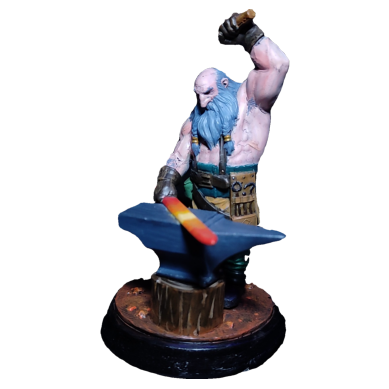

In [9]:
from ultralytics import SAM
%matplotlib inline

rect_start = None
rect_end = None
drawing = False

source = "frames/frame_0073.png"
model = SAM("models/sam_l.pt")

coordinates = interactive_bbox_selection(source)
segmenting_image(coordinates, model, source)

## 3D reconstruction from videos

### Extract frames from Video

In [ ]:
import cv2
import os
from tqdm import tqdm

def extract_frames(video_path, output_folder = "frames", frame_interval = 30):
    """"
    Extract the frames from a video.

    Args:
        video_path (str): The path to the video to be extracted.
        output_folder (str): The path to save the extracted frames.
        frame_interval (int): The interval of frames within the frames will be extracted
    
    Returns:
        Extracted frames will be saved in the output_folder in png format
    
    """

    if not os.path.exists(output_folder):
        os.mkdir(output_folder)

    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    extracted_count = 0
    
    # Get rotation information
    rotation = int(cap.get(cv2.CAP_PROP_ORIENTATION_META))
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print("------ Extracting frames ------")
    
    with tqdm(total=total_frames, unit="frame") as pbar:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            # Apply rotation correction based on metadata
            if rotation == 90:
                frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
            elif rotation == 180:
                frame = cv2.rotate(frame, cv2.ROTATE_180)
            elif rotation == 270:
                frame = cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE)
            
            # Save frame
            if frame_count % frame_interval == 0:
                frame_filename = os.path.join(output_folder, f"frame_{extracted_count:04d}.png")

                cv2.imwrite(frame_filename, frame)
                
                extracted_count += 1
            
            frame_count += 1
            pbar.update(1)
        cap.release()

In [ ]:
extract_frames("videos/Adventurer.mp4", "frames", 30)

### Segmenting Images

In [11]:
import torch
import numpy as np
import os
from tqdm import tqdm
from ultralytics import SAM

def segmenting_image(input_folder,  output_folder, coordinates):
    
    """"
    Segment the desired image from the extracted video frames.

    Args:
        input_folder (str): The path to the folder containing the video frames.
        output_folder (str): The path to the folder where the segmented images will be savedd.
        coordinates (array): Array with the rectangle coordinates which the desired image is within. The format is [xmin, ymin, xmax, ymax].
    
    Returns:
        Save the segmented images with a black background in the output_folder
    
    """

    model = SAM("models/sam2_l.pt")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if not os.path.exists(output_folder):
        os.mkdir(output_folder)

    print("------ Segmenting images ------")

    for file in tqdm(os.listdir(input_folder), unit="Images"):
        
        results = model.predict(os.path.join(input_folder, file),
                                device=device,
                                imgsz=1024,
                                bboxes=coordinates,
                                conf=0.25,
                                verbose=False)
        
        for result in results:
            img = np.copy(result.orig_img)
            for ci, c in enumerate(result):
                b_mask = np.zeros(img.shape[:2], np.uint8)

                # Create contour mask 
                contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
                cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)

                res = cv2.bitwise_and(img, img, mask=b_mask)
                
                contour = contour.reshape(-1, 2)
                x_min, y_min = np.min(contour, axis=0)
                x_max, y_max = np.max(contour, axis=0)
                
                # Crop the image to get only the segmented object
                cropped_image = res[y_min:y_max, x_min:x_max]
                cv2.imwrite(os.path.join(os.path.join(output_folder, file)), cropped_image)

In [12]:
coordinates = [123, 65, 948, 1673]
segmenting_image("frames", "segmented_images", coordinates)

------ Segmenting images ------


100%|██████████| 34/34 [03:34<00:00,  6.30s/Images]


### Depth maps

In [13]:
# Importing libraries
from PIL import Image
import torch
import numpy as np
import open3d as o3d
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import os
from tqdm import tqdm

def creating_depth_maps(input_folder, output_folder):
    """"
    Use the segmented images to create the depth maps.

    Args:
        input_folder (str): The path to the folder containing the segmented image.
        output_folder (str): The path to the folder where the depth maps will be savedd.
    
    Returns:
        Save the depth map as a numpy array in the output_folder
        Saves the resized segmented image in the input_folder
        new_size (int, int): the resized size of the image and depth maps
    """
    
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    feature_extractor = AutoImageProcessor.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf")
    model = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf").to(device)

    for image_path in tqdm(os.listdir(input_folder), desc="Creating depth maps"):
        image = Image.open(os.path.join(input_folder, image_path))

        # Loading and resizing the image
        new_height = 1000 if image.height > 1000 else image.height
        new_height -= (new_height % 32)
        new_width = int(new_height * image.width / image.height)
        diff = new_width % 32

        new_width = new_width - diff if diff < 16 else new_width + 32 - diff
        new_size = (new_width, new_height)
        image = image.resize(new_size)

        image.save(os.path.join(input_folder, image_path))

        # Preparing the image for the model
        inputs = feature_extractor(images=image, return_tensors="pt").to(device)
        
        # Getting the prediction
        with torch.no_grad():
            outputs = model(**inputs)
        
        predicted_depth = feature_extractor.post_process_depth_estimation(
            outputs, target_sizes=[(image.height, image.width)],
        )

        # Post-processing
        depth = predicted_depth[0]["predicted_depth"]
        depth = (depth - depth.min()) / (depth.max() - depth.min())
        depth = depth * 255.
        depth = depth.detach().cpu().numpy()

        depth_image = (depth * 255 / np.max(depth)).astype('uint8')
        image = np.array(image)

        depth_o3d = o3d.geometry.Image(depth_image)
        kp_path = os.path.join(output_folder, os.path.splitext(image_path)[0]+".npy")
        np.save(kp_path, np.asarray(depth_o3d, dtype=object))
    
    
    print("-------- All depth maps created --------")
    return new_size

In [ ]:
new_size = creating_depth_maps(input_folder = "segmented_images", output_folder = "depth_maps")

### Feature Extraction and Matching 

In [12]:
import os
import cv2
import kornia as K
import kornia.feature as KF
import torch
import numpy as np
from tqdm import tqdm
from kornia_moons.viz import draw_LAF_matches
import matplotlib.pyplot as plt

def extract_and_match_keypoints(input_folder, output_folder, new_size, save_images=True):
    
    """"
    Use a deep learning model to extract and match keypoints between consecutive frames from a folder.

    Args:
        input_folder (str): The path to the folder containing the segmented images.
        output_folder (str): The path to the folder where the matched keypoints and images will be saved.
        save_images (bool): Save the matched features visual representations in the folder or not.
    
    Returns:
        Save the npz file with matches in the output_folder
        Saves the visualization of the matches in the output_folder
    """

    os.makedirs(output_folder, exist_ok=True)
    # Load image filenames and sort them
    image_files = sorted([f for f in os.listdir(input_folder) if f.endswith(".png")])

    # Initialize matcher
    matcher = KF.LoFTR(pretrained="indoor_new")

    # Loop over image pairs
    for i in tqdm(range(len(image_files) - 1), desc="Matching image pairs"):
        fname1 = os.path.join(input_folder, image_files[i])
        fname2 = os.path.join(input_folder, image_files[i + 1])

        # Load and preprocess images
        img1 = K.io.load_image(fname1, K.io.ImageLoadType.RGB32)[None, ...]
        img2 = K.io.load_image(fname2, K.io.ImageLoadType.RGB32)[None, ...]
        img1 = K.geometry.resize(img1, new_size, antialias=True)
        img2 = K.geometry.resize(img2, new_size, antialias=True)

        input_dict = {
            "image0": K.color.rgb_to_grayscale(img1),
            "image1": K.color.rgb_to_grayscale(img2),
        }

        with torch.inference_mode():
            correspondences = matcher(input_dict)

        mkpts0 = correspondences["keypoints0"].cpu().numpy()
        mkpts1 = correspondences["keypoints1"].cpu().numpy()

        # Estimate fundamental matrix and find inliers
        if len(mkpts0) >= 8:
            Fm, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 1.0, 0.999, 100000)
            inliers = inliers > 0
        else:
            inliers = np.zeros((len(mkpts0), 1), dtype=bool)

        # Save npz file with matches
        npz_filename = os.path.join(output_folder, f"match_{i:04d}_{i+1:04d}.npz")
        np.savez_compressed(npz_filename, keypoints0=mkpts0, keypoints1=mkpts1, inliers=inliers)
        
        if save_images:

            os.makedirs(os.path.join(output_folder, "images"), exist_ok=True)
            # Optional: Save visualization
            draw_LAF_matches(
                KF.laf_from_center_scale_ori(
                    torch.from_numpy(mkpts0).view(1, -1, 2),
                    torch.ones(mkpts0.shape[0]).view(1, -1, 1, 1),
                    torch.ones(mkpts0.shape[0]).view(1, -1, 1),
                ),
                KF.laf_from_center_scale_ori(
                    torch.from_numpy(mkpts1).view(1, -1, 2),
                    torch.ones(mkpts1.shape[0]).view(1, -1, 1, 1),
                    torch.ones(mkpts1.shape[0]).view(1, -1, 1),
                ),
                torch.arange(mkpts0.shape[0]).view(-1, 1).repeat(1, 2),
                K.tensor_to_image(img1),
                K.tensor_to_image(img2),
                inliers,
                draw_dict={
                    "inlier_color": (0.2, 1, 0.2),
                    "tentative_color": (1.0, 0.5, 1),
                    "feature_color": (0.2, 0.5, 1),
                    "vertical": False,
                },
            )
            
            plt.savefig(os.path.join(os.path.join(output_folder, "images"), f"match_{i:04d}_{i+1:04d}.png"))
            plt.close()

In [17]:
extract_and_match_keypoints("segmented_images", "matches", (448, 992), save_images=False)

Matching image pairs: 100%|██████████| 33/33 [02:23<00:00,  4.34s/it]


### Reconstructing Camera Poses

In [ ]:
class CameraPoseEstimator:
    def __init__(self, matches_folder, image_folder=None, K_matrix=None):
        """
        Initialize camera pose estimator.
        
        Args:
            matches_folder (str): Path to folder containing feature matches (.npz files)
            image_folder (str): Path to folder containing images (optional)
            K_matrix (np.ndarray): 3x3 camera intrinsic matrix (optional)
        """
        self.matches_folder = matches_folder
        self.image_folder = image_folder
        
        # Default camera intrinsics if not provided (adjust based on your camera)
        if K_matrix is None:
            self.K = np.array([
                [1000, 0, 500],
                [0, 1000, 500],
                [0, 0, 1]
            ], dtype=np.float64)
        else:
            self.K = K_matrix
            
        # Store camera poses (rotation and translation)
        self.camera_poses = {}
        self.camera_centers = {}
        
        # Store 3D points
        self.points_3d = []
        self.point_colors = []
        self.point_track_ids = []
        
        # Load all match files
        self.match_files = sorted([f for f in os.listdir(matches_folder) if f.endswith(".npz")])
        
        # Store matches between frames
        self.frame_matches = {}
        self.load_matches()
        
    def load_matches(self):
        """Load all feature matches from NPZ files"""
        for match_file in self.match_files:
            # Parse frame indices from filename (match_0000_0001.npz)
            parts = match_file.split('_')
            idx1 = int(parts[1])
            idx2 = int(parts[2].split('.')[0])
            
            # Load matches
            data = np.load(os.path.join(self.matches_folder, match_file))
            kpts1 = data['keypoints0']
            kpts2 = data['keypoints1']
            inliers = data['inliers'].flatten()
            
            # Filter to only keep inliers
            kpts1_inliers = kpts1[inliers]
            kpts2_inliers = kpts2[inliers]
            
            self.frame_matches[(idx1, idx2)] = {
                'kpts1': kpts1_inliers,
                'kpts2': kpts2_inliers,
                'count': len(kpts1_inliers)
            }
    
    def select_initial_pair(self):
        """
        Select initial image pair with good matches and geometry
        For sequential frames, we'll use frame 0 and 1 as specified
        """
        # As specified, use frames 0 and 1 as the initial pair for sequential data
        return 0, 1
    
    def compute_fundamental_matrix(self, pts1, pts2):
        """
        Compute fundamental matrix between two sets of points
        
        Args:
            pts1, pts2: Matched points in two images (Nx2 arrays)
            
        Returns:
            F: 3x3 fundamental matrix
            mask: Boolean array indicating inliers
        """
        F, mask = cv2.findFundamentalMat(
            pts1, pts2, method=cv2.FM_RANSAC, ransacReprojThreshold=1.0, confidence=0.999, maxIters=10000
        )
        
        mask = mask.astype(bool).reshape(-1)
        return F, mask
    
    def compute_essential_matrix(self, F):
        """
        Compute essential matrix E from fundamental matrix F
        E = K.T * F * K
        """
        E = self.K.T @ F @ self.K
        return E
    
    def decompose_essential_matrix(self, E, pts1, pts2):
        """
        Decompose essential matrix to get camera pose (R, t)
        
        Args:
            E: Essential matrix
            pts1, pts2: Matched points in two images (for determining correct solution)
            
        Returns:
            R: 3x3 rotation matrix
            t: 3x1 translation vector
        """
        # Ensure E is well-conditioned
        U, S, Vt = np.linalg.svd(E)
        if np.abs(S[0] - S[1]) > 1e-3 or S[2] > 1e-3:
            # Enforce the condition that the first two singular values are equal and the third is zero
            S = np.array([0.5 * (S[0] + S[1]), 0.5 * (S[0] + S[1]), 0.0])
            E = U @ np.diag(S) @ Vt
        
        # Decompose essential matrix into 4 possible solutions
        R1, R2, t = cv2.decomposeEssentialMat(E)
        t = t.reshape(3, 1)
        
        # Four possible solutions: (R1, t), (R1, -t), (R2, t), (R2, -t)
        Rs = [R1, R1, R2, R2]
        ts = [t, -t, t, -t]
        
        # Convert points to homogeneous coordinates
        pts1_norm = cv2.undistortPoints(pts1.reshape(-1, 1, 2), self.K, None)
        pts2_norm = cv2.undistortPoints(pts2.reshape(-1, 1, 2), self.K, None)
        
        # Check which solution gives positive depth for most points
        max_points = 0
        best_R, best_t = None, None
        
        for i in range(4):
            R_test, t_test = Rs[i], ts[i]
            
            # Create projection matrices
            P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
            P2 = np.hstack((R_test, t_test))
            
            # Triangulate points
            points_4d = cv2.triangulatePoints(P1, P2, pts1_norm.reshape(-1, 2).T, pts2_norm.reshape(-1, 2).T)
            points_3d = points_4d / points_4d[3]
            
            # Check points in front of both cameras
            # Transform points to camera 2
            points_3d_cam2 = R_test @ points_3d[:3] + t_test
            
            # Count points with positive depth in both cameras
            n_positive = np.sum((points_3d[2] > 0) & (points_3d_cam2[2] > 0))
            
            if n_positive > max_points:
                max_points = n_positive
                best_R, best_t = R_test, t_test
        
        # Ensure rotation matrix is valid (det(R) = 1)
        if np.linalg.det(best_R) < 0:
            best_R = -best_R
            best_t = -best_t
        
        return best_R, best_t
    
    def triangulate_points(self, pts1, pts2, P1, P2):
        """
        Triangulate 3D points from 2D correspondences
        
        Args:
            pts1, pts2: Matched points in two images (Nx2 arrays)
            P1, P2: 3x4 projection matrices for the two cameras
            
        Returns:
            points_3d: Nx3 array of triangulated 3D points
        """
        # Normalize points using camera intrinsics
        pts1_norm = cv2.undistortPoints(pts1.reshape(-1, 1, 2), self.K, None).reshape(-1, 2)
        pts2_norm = cv2.undistortPoints(pts2.reshape(-1, 1, 2), self.K, None).reshape(-1, 2)
        
        # Triangulate
        points_4d = cv2.triangulatePoints(P1, P2, pts1_norm.T, pts2_norm.T)
        
        # Convert from homogeneous to 3D
        points_3d = points_4d[:3] / points_4d[3]
        
        return points_3d.T
    
    def compute_camera_poses(self):
        """
        Compute camera poses for sequential frames
        """
        # Select initial pair (frames 0 and frame 1)
        idx1, idx2 = self.select_initial_pair()
        
        if (idx1, idx2) not in self.frame_matches:
            raise ValueError(f"No matches found between frames {idx1} and {idx2}")
        
        # Get matches for initial pair
        matches = self.frame_matches[(idx1, idx2)]
        pts1, pts2 = matches['kpts1'], matches['kpts2']
        
        # Compute fundamental matrix and filter outliers
        F, inliers = self.compute_fundamental_matrix(pts1, pts2)
        pts1, pts2 = pts1[inliers], pts2[inliers]
        
        # Compute essential matrix
        E = self.compute_essential_matrix(F)
        
        # Decompose essential matrix to get R, t
        R, t = self.decompose_essential_matrix(E, pts1, pts2)
        
        # Set first camera as world origin [I|0]
        self.camera_poses[idx1] = {
            'R': np.eye(3),
            't': np.zeros((3, 1)),
            'P': np.hstack((np.eye(3), np.zeros((3, 1))))
        }
        
        # Set second camera position [R|t]
        self.camera_poses[idx2] = {
            'R': R,
            't': t,
            'P': np.hstack((R, t))
        }
        
        # Calculate camera centers (for visualization)
        self.camera_centers[idx1] = np.zeros(3)  # Origin
        self.camera_centers[idx2] = -R.T @ t.reshape(3)  # C = -R^T * t
        
        print(f"Initialized camera poses for frames {idx1} and {idx2}")
        
        # Process remaining frames sequentially
        last_processed_frame = idx2
        
        # Keep track of 3D points and their 2D projections
        P1 = self.camera_poses[idx1]['P']
        P2 = self.camera_poses[idx2]['P']
        
        # Triangulate initial points between first two frames
        initial_points_3d = self.triangulate_points(pts1, pts2, 
                                                   self.K @ P1, 
                                                   self.K @ P2)
        
        # Store 3D points with corresponding 2D observations
        point_observations = {}
        for i in range(len(initial_points_3d)):
            point_id = i
            point_observations[point_id] = {
                idx1: pts1[i],
                idx2: pts2[i]
            }
        
        # Process remaining frames
        max_frame_idx = int(self.match_files[-1].split('_')[2].split('.')[0]) + 1
        
        # Check if we have matches for connecting the last frame to the first (for 360° loop)
        has_loop_closure = False
        last_frame = max_frame_idx - 1
        
        # Look for match between last and first frame (loop closure)
        for match_file in self.match_files:
            parts = match_file.split('_')
            if len(parts) >= 3:
                idx_a = int(parts[1])
                idx_b = int(parts[2].split('.')[0])
                if (idx_a == last_frame and idx_b == idx1) or (idx_a == idx1 and idx_b == last_frame):
                    has_loop_closure = True
                    print(f"Found loop closure between frames {last_frame} and {idx1}")
                    break
        
        # Process frames sequentially
        for i in range(idx2 + 1, max_frame_idx):
            if (i - 1, i) not in self.frame_matches:
                print(f"No matches found between frames {i-1} and {i}")
                continue
                
            print(f"Processing frame {i}...")
            
            # Find 3D points that are visible in the current frame
            matches = self.frame_matches[(i-1, i)]
            pts_prev = matches['kpts1']
            pts_curr = matches['kpts2']
            
            # Get the camera pose of the previous frame
            prev_R = self.camera_poses[i-1]['R']
            prev_t = self.camera_poses[i-1]['t']
            
            # Compute fundamental matrix between frames i-1 and i
            F_new, inliers_new = self.compute_fundamental_matrix(pts_prev, pts_curr)
            pts_prev_inliers = pts_prev[inliers_new]
            pts_curr_inliers = pts_curr[inliers_new]
            
            if len(pts_prev_inliers) < 8:
                print(f"Too few inliers ({len(pts_prev_inliers)}) to compute pose for frame {i}")
                continue
                
            E_new = self.compute_essential_matrix(F_new)
            
            # Decompose essential matrix for relative pose
            R_rel, t_rel = self.decompose_essential_matrix(E_new, pts_prev_inliers, pts_curr_inliers)
            
            # Scale the translation to help shape the trajectory
            # For a 360° camera path, you might need to adjust this scale factor
            # Larger values create wider circles, smaller values create tighter circles
            translation_scale = 0.5  # Adjust this value to change the shape of the trajectory
            
            # Compute absolute pose
            R_new = R_rel @ prev_R
            t_new = R_rel @ prev_t + t_rel * translation_scale
            
            # Store the new camera pose
            self.camera_poses[i] = {
                'R': R_new,
                't': t_new,
                'P': np.hstack((R_new, t_new))
            }
            
            # Calculate camera center
            self.camera_centers[i] = -R_new.T @ t_new.reshape(3)
        
        # If we have a loop closure, try to adjust the poses to close the loop
        if has_loop_closure and last_frame in self.camera_poses and idx1 in self.camera_poses:
            self._adjust_for_loop_closure(idx1, last_frame)
            
        print(f"Computed poses for {len(self.camera_poses)} cameras")
        
    def _adjust_for_loop_closure(self, first_frame, last_frame):
        """
        Adjust camera poses to close the loop between first and last frames
        Simple interpolation method to distribute the drift
        
        Args:
            first_frame: Index of the first frame
            last_frame: Index of the last frame
        """
        print(f"Adjusting poses for loop closure between frames {first_frame} and {last_frame}")
        
        # Get first and last camera centers
        first_center = self.camera_centers[first_frame]
        last_center = self.camera_centers[last_frame]
        
        # Calculate the drift (error)
        drift = last_center - first_center
        
        # Get all frame indices in order
        frames = sorted(self.camera_poses.keys())
        n_frames = len(frames)
        
        # Distribute the drift across all frames
        for i, frame_idx in enumerate(frames):
            if frame_idx == first_frame:
                continue  # Don't adjust the first frame
                
            # Calculate correction factor (linear interpolation)
            # The closer to the last frame, the larger the correction
            correction_factor = i / (n_frames - 1)
            
            # Apply correction to camera center
            self.camera_centers[frame_idx] -= drift * correction_factor
            
            # Update translation from corrected center
            R = self.camera_poses[frame_idx]['R']
            corrected_center = self.camera_centers[frame_idx]
            self.camera_poses[frame_idx]['t'] = -R @ corrected_center.reshape(3, 1)
            
            # Update projection matrix
            self.camera_poses[frame_idx]['P'] = np.hstack((R, self.camera_poses[frame_idx]['t']))
        
    def plot_camera_trajectory(self, ax=None, show=True):
        """
        Plot camera trajectory in 3D
        
        Args:
            ax: Matplotlib 3D axis (optional)
            show: Whether to show the plot (default: True)
        """
        if ax is None:
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')
        
        # Extract camera centers
        frame_ids = sorted(self.camera_centers.keys())
        positions = np.array([self.camera_centers[idx] for idx in frame_ids])
        
        # Plot camera trajectory
        ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], 'b-', linewidth=1)
        
        # Plot camera positions
        ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c='r', s=50)
        
        # Add camera ID labels
        for i, frame_id in enumerate(frame_ids):
            ax.text(positions[i, 0], positions[i, 1], positions[i, 2], f'{frame_id}', fontsize=8)
        
        # Set equal aspect ratio
        max_range = np.max([
            np.ptp(positions[:, 0]),
            np.ptp(positions[:, 1]), 
            np.ptp(positions[:, 2])
        ])
        
        mid_x = np.mean(positions[:, 0])
        mid_y = np.mean(positions[:, 1])
        mid_z = np.mean(positions[:, 2])
        
        ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
        ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
        ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('Camera Trajectory')
        
        if show:
            plt.tight_layout()
            plt.show()
            
        return ax

Initialized camera poses for frames 0 and 1
Processing frame 2...
Processing frame 3...
Processing frame 4...
Processing frame 5...
Processing frame 6...
Processing frame 7...
Processing frame 8...
Processing frame 9...
Processing frame 10...
Processing frame 11...
Processing frame 12...
Processing frame 13...
Processing frame 14...
Processing frame 15...
Processing frame 16...
Processing frame 17...
Processing frame 18...
Processing frame 19...
Processing frame 20...
Processing frame 21...
Processing frame 22...
Processing frame 23...
Processing frame 24...
Processing frame 25...
Processing frame 26...
Processing frame 27...
Processing frame 28...
Processing frame 29...
Processing frame 30...
Processing frame 31...
Processing frame 32...
Processing frame 33...
Computed poses for 34 cameras


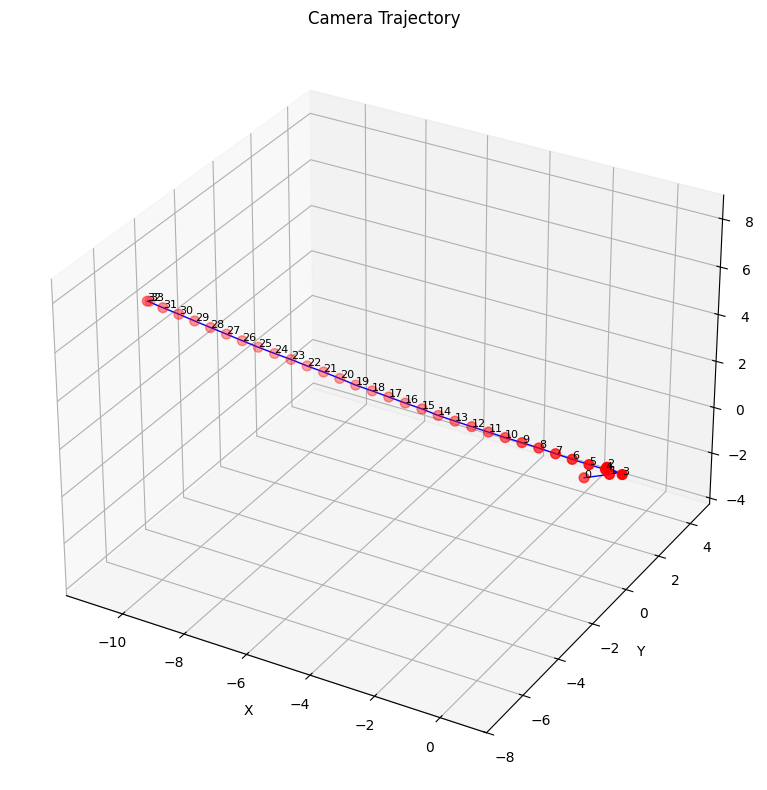

Saved camera poses to ./camera_poses\camera_poses.npy


In [18]:
output_folder = "./camera_poses"
matches_folder = "./matches"

if output_folder:
    os.makedirs(output_folder, exist_ok=True)

# Initialize pose estimator with custom camera intrinsics if needed
K_matrix = np.array([
    [224, 0, 525],  # fx, 0, cx
    [0, 496, 525],  # 0, fy, cy
    [0, 0, 1]        # 0, 0, 1
])

estimator = CameraPoseEstimator(matches_folder, K_matrix=K_matrix)

# Compute camera poses
estimator.compute_camera_poses()

# Visualize results
estimator.plot_camera_trajectory()

# Save camera poses if output folder is specified
if output_folder:
    camera_data = {
        'poses': {},
        'centers': {}
    }
    
    for idx, pose in estimator.camera_poses.items():
        camera_data['poses'][idx] = {
            'R': pose['R'],
            't': pose['t'],
            'P': pose['P']
        }
        camera_data['centers'][idx] = estimator.camera_centers[idx]
    
    np.save(os.path.join(output_folder, 'camera_poses.npy'), camera_data)
    print(f"Saved camera poses to {os.path.join(output_folder, 'camera_poses.npy')}")

In [6]:
import os
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def load_matches(match_folder):
    """Load all match files from the folder and return as a list of dictionaries"""
    match_files = sorted([f for f in os.listdir(match_folder) if f.endswith(".npz")])
    matches = []
    for f in match_files:
        data = np.load(os.path.join(match_folder, f))
        matches.append({
            'keypoints0': data['keypoints0'],
            'keypoints1': data['keypoints1'],
            'inliers': data['inliers']
        })
    return matches

def fuse_matches_to_tracks(matches):
    """Fuse matches between consecutive frames into tracks"""
    tracks = []
    track_id = 0
    
    # Create tracks from first pair
    pair_matches = matches[0]
    inliers = pair_matches['inliers'].squeeze()
    kp0 = pair_matches['keypoints0'][inliers]
    kp1 = pair_matches['keypoints1'][inliers]
    
    for (pt0, pt1) in zip(kp0, kp1):
        tracks.append({
            'id': track_id,
            'points': {0: pt0, 1: pt1},
            'colors': None  # We're not using colors here
        })
        track_id += 1
    
    # For subsequent pairs, try to extend existing tracks
    for i in range(1, len(matches)):
        pair_matches = matches[i]
        inliers = pair_matches['inliers'].squeeze()
        kp0 = pair_matches['keypoints0'][inliers]
        kp1 = pair_matches['keypoints1'][inliers]
        
        # For simplicity, we'll just create new tracks for each pair
        # In a more complete implementation, you'd match against existing tracks
        for (pt0, pt1) in zip(kp0, kp1):
            tracks.append({
                'id': track_id,
                'points': {i: pt0, i+1: pt1},
                'colors': None
            })
            track_id += 1
    
    return tracks

def estimate_initial_pose(matches, tracks):
    """Estimate initial pose between first two frames"""
    # We'll use the first two frames as our initial pair as requested
    pair_idx = 0
    
    # Get matches between first two frames
    pair_matches = matches[pair_idx]
    inliers = pair_matches['inliers'].squeeze()
    kp0 = pair_matches['keypoints0'][inliers]
    kp1 = pair_matches['keypoints1'][inliers]
    
    # Estimate fundamental matrix
    F, mask = cv2.findFundamentalMat(kp0, kp1, cv2.FM_RANSAC, 1.0, 0.99)
    mask = mask.ravel() == 1
    
    # Estimate essential matrix (assuming known camera intrinsics)
    # For simplicity, we'll assume identity matrix for intrinsics here
    # In practice, you should use real camera calibration
    K = np.eye(3)
    E = K.T @ F @ K
    
    # Recover pose from essential matrix
    _, R, t, _ = cv2.recoverPose(E, kp0[mask], kp1[mask], K)
    
    # Camera poses: first camera is at origin, second camera is R,t
    poses = {
        0: {'R': np.eye(3), 't': np.zeros((3, 1))},
        1: {'R': R, 't': t}
    }
    
    return poses, kp0[mask], kp1[mask]

def triangulate_points(pose0, pose1, kp0, kp1):
    """Triangulate 3D points from two camera poses and corresponding keypoints"""
    # For simplicity, assuming identity camera matrix
    K = np.eye(3)
    
    # Projection matrices
    P0 = K @ np.hstack((pose0['R'], pose0['t']))
    P1 = K @ np.hstack((pose1['R'], pose1['t']))
    
    # Triangulate points
    points_4d = cv2.triangulatePoints(P0, P1, kp0.T, kp1.T)
    points_3d = points_4d[:3] / points_4d[3]
    
    return points_3d.T

def pnp_ransac(kp, points_3d, reproj_thresh=3.0, max_iters=1000):
    """Estimate camera pose using Perspective-n-Point with RANSAC"""
    # For simplicity, assuming identity camera matrix
    K = np.eye(3)
    
    # Ensure we have enough points and they're in correct format
    if len(points_3d) < 4 or len(kp) < 4 or len(points_3d) != len(kp):
        return None, None, None
    
    # Convert points to float32 if needed
    points_3d = np.asarray(points_3d, dtype=np.float32)
    kp = np.asarray(kp, dtype=np.float32)
    
    # Find inliers using RANSAC
    try:
        success, rvec, t, inliers = cv2.solvePnPRansac(
            points_3d, kp, K, None,
            reprojectionError=reproj_thresh,
            iterationsCount=max_iters,
            flags=cv2.SOLVEPNP_EPNP
        )
        
        if not success:
            return None, None, None
        
        # Convert rotation vector to matrix
        R, _ = cv2.Rodrigues(rvec)
        return R, t, inliers
    except:
        return None, None, None

def incremental_sfm(matches, tracks):
    """Incremental structure from motion for camera pose estimation"""
    # Step 1: Estimate initial pose between first two frames
    poses, kp0, kp1 = estimate_initial_pose(matches, tracks)
    
    # Step 2: Triangulate initial 3D points
    points_3d = triangulate_points(poses[0], poses[1], kp0, kp1)
    
    # Keep track of which points are visible in which frames
    visible_points = {}  # Maps frame index to list of (kp_idx, point_3d_idx)
    point_3d_to_kp = {}  # Maps point_3d_idx to {frame_idx: kp_idx}
    
    # Initialize visibility for first two frames
    for i, pt in enumerate(points_3d):
        point_3d_to_kp[i] = {0: i, 1: i}
    
    # Step 3: Incrementally add new views
    for frame_idx in range(2, len(matches)+1):
        print(f"Processing frame {frame_idx}")
        
        # Get matches between previous and current frame
        pair_matches = matches[frame_idx-1]
        inliers = pair_matches['inliers'].squeeze()
        kp_prev = pair_matches['keypoints0'][inliers]  # Points in previous frame
        kp_curr = pair_matches['keypoints1'][inliers]  # Points in current frame
        
        # Find which of these points have 3D coordinates
        valid_3d_points = []
        valid_kp = []
        
        for i, kp in enumerate(kp_curr):
            # Check if this point was tracked from previous frame
            # and has a 3D point associated
            # This is simplified - in real implementation you'd need proper tracking
            if frame_idx-1 in poses and i < len(points_3d):
                valid_3d_points.append(points_3d[i])
                valid_kp.append(kp)
        
        # Need at least 4 points to estimate pose
        if len(valid_3d_points) >= 4:
            R, t, inliers = pnp_ransac(valid_kp, valid_3d_points)
            
            if R is not None:
                poses[frame_idx] = {'R': R, 't': t}
                
                # Triangulate new points between this frame and previous frame
                # Only use inliers for triangulation
                inliers = inliers.squeeze()
                if len(inliers) > 0:
                    new_points = triangulate_points(
                        poses[frame_idx-1], poses[frame_idx], 
                        kp_prev[inliers], kp_curr[inliers]
                    )
                    
                    # Add new points to our 3D points
                    if len(new_points) > 0:
                        points_3d = np.vstack((points_3d, new_points))
    
    return poses

def plot_camera_poses(poses):
    """Plot the estimated camera positions in 3D"""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Extract camera positions
    positions = []
    for frame_idx in sorted(poses.keys()):
        R = poses[frame_idx]['R']
        t = poses[frame_idx]['t']
        # Camera position is -R^T * t
        pos = -R.T @ t
        positions.append(pos)
    
    positions = np.array(positions).squeeze()
    
    # Plot camera positions
    ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c='r', marker='o')
    
    # Draw lines between consecutive cameras
    for i in range(len(positions)-1):
        ax.plot(
            [positions[i, 0], positions[i+1, 0]],
            [positions[i, 1], positions[i+1, 1]],
            [positions[i, 2], positions[i+1, 2]],
            'b-'
        )
    
    # Label cameras
    for i, pos in enumerate(positions):
        ax.text(pos[0], pos[1], pos[2], f'Cam {i}')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Estimated Camera Poses')
    plt.show()

In [ ]:
match_folder = "./matches"

matches = load_matches(match_folder)
    
# Step 2: Fuse matches into tracks
tracks = fuse_matches_to_tracks(matches)

# Step 3-6: Incremental SFM for pose estimation
poses = incremental_sfm(matches, tracks)

# Plot camera poses
plot_camera_poses(poses)

## Pre-painting - coloring sketch

### Converting image to sketch

In [ ]:
# Import all the required modules
import numpy as np
import imageio
import scipy.ndimage
import cv2
 
img = "test.png"
 
# Function to convert image into sketch
def rgb2gray(rgb):
    # 2 dimensional array to convert image to sketch
    return np.dot(rgb[..., :3], [0.2989, 0.5870, .1140])
 
def dodge(front, back):
 
    # If image is greater than 255 (which is not possible) it will convert it to 255
    final_sketch = front*255/(255-back)
    final_sketch[final_sketch > 255] = 255
    final_sketch[back == 255] = 255
 
    # To convert any suitable existing column to categorical type we will use aspect function
    # And uint8 is for 8-bit signed integer
    return final_sketch.astype('uint8')
 
ss = imageio.imread(img)
gray = rgb2gray(ss)
 
i = 255-gray
 
# To convert into a blur image
blur = scipy.ndimage.filters.gaussian_filter(i, sigma=13)
 
# Calling the function
r = dodge(blur, gray)

cv2.imwrite('sketch.png', r)

### Creating a color pallete

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Initialize an empty dictionary to store text and color hex values
text_color_dict = {}

# Function to handle the submission of text and color
def submit_text_color(text, color):
    text_color_dict[text] = color
    print(f"Added: {text} with color {color}")

# Function to handle the submission of text and color
def delete_text_color(dict):
    dict.clear()
    print(f"Dictionary deleted")

# Create text input widget
text_input = widgets.Text(
    value='',
    placeholder='Type something',
    description='Text:',
    disabled=False
)

# Create color picker widget
color_picker = widgets.ColorPicker(
    value='#ff0000',
    description='Pick a color',
    disabled=False
)

# Create a button to submit the text and color
submit_button = widgets.Button(
    description='Submit',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to submit text and color',
    icon='check'
)

# Create a button to clear the dictionary
delete_button = widgets.Button(
    description='Clear',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to submit text and color',
    icon='delete'
)

# Define the button click event handler
def on_submit_button_clicked(b):
    submit_text_color(text_input.value, color_picker.value)
    text_input.value = ''  # Clear the text input after submission

# Define the button click event handler
def on_delete_button_clicked(b):
    delete_text_color(text_color_dict)
    text_input.value = ''  # Clear the text input after submission

# Attach the event handler to the button
submit_button.on_click(on_submit_button_clicked)
delete_button.on_click(on_delete_button_clicked)

# Display the widgets
display(text_input, color_picker, submit_button, delete_button)

In [ ]:
print(text_color_dict)

### Generating the PDF file with the sketch, parts, HEX code and square with correspondent color

In [14]:
from reportlab.lib.pagesizes import letter
from reportlab.lib.units import inch
from reportlab.lib.colors import HexColor
from reportlab.pdfgen import canvas
from PIL import Image as PILImage

def generate_pdf(image_path, text_color_dict, output_path="sketch.pdf"):
    c = canvas.Canvas(output_path, pagesize=letter)
    width, height = letter

    # Set margins
    margin = 0.5 * inch
    text_x = margin
    text_y = height - margin

    # Load the image
    img = PILImage.open(image_path)
    img_width, img_height = img.size

    # Resize the image to fit within a constant size while keeping proportions
    aspect_ratio = img_width / img_height
    img_height = 500
    img_width = int(img_height * aspect_ratio)

    # Calculate the position to center the image on the right part
    img_x = width - img_width - margin
    img_y = (height - img_height) / 2

    # Draw the image
    c.drawImage(image_path, img_x, img_y, width=img_width, height=img_height)

    # Draw the dictionary items
    column_width = (width - img_width - 2 * margin) / 2
    for i, (text, color) in enumerate(text_color_dict.items()):
        if text_y < margin:
            text_x += column_width
            text_y = height - margin

        c.setFillColor(HexColor(color))
        c.rect(text_x, text_y - 10, 10, 10, fill=1)
        c.setFillColor(HexColor("#000000"))
        c.drawString(text_x + 15, text_y - 10, f"{text}: {color}")
        text_y -= 20

    c.save()

# Example usage:
generate_pdf("sketch.png", text_color_dict)